In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
Ts = 501
segments = 12 # beads = 13

In [3]:
f = []; m1 = []; m2 = []

for i in range(Ts):
    f_ = pd.read_csv('data5/Filament_5s133R0.8Ts'+str(i)+'.csv', names=['x','y','z'], skiprows=1)
    f.append(f_)
    m1_ = pd.read_csv('data5/Specie1_5s133R0.8Ts'+str(i)+'.csv', names=['x','y','z'], skiprows=1)
    m1.append(m1_)
    m2_ = pd.read_csv('data5/Specie2_5s133R0.8Ts'+str(i)+'.csv', names=['x','y','z'], skiprows=1)
    m2.append(m2_)

In [4]:
m1all = m1[0].drop(['z'], axis=1)
m2all = m2[0].drop(['z'], axis=1)

for i in range(Ts-1):
    m1all = m1all.append(m1[i+1].drop(['z'], axis=1))
    m2all = m2all.append(m2[i+1].drop(['z'], axis=1))

In [5]:
# Identify the time step

Ts_count = 0
m1_ts_no = []

for i in m1all.index == 0: # check all index having 0 (starting point of a time step)
    if i == True:
        m1_ts_no.append(Ts_count)
        Ts_count+=1
    else:
        m1_ts_no.append(Ts_count-1)

m1_ts_no = np.array(m1_ts_no) # make np array
m1_ts_no = pd.DataFrame({'Ts':m1_ts_no}) # make pd dataframe

In [6]:
# Identify the time step

Ts_count = 0
m2_ts_no = []

for i in m2all.index == 0: # check all index having 0 (starting point of a time step)
    if i == True:
        m2_ts_no.append(Ts_count)
        Ts_count+=1
    else:
        m2_ts_no.append(Ts_count-1)

m2_ts_no = np.array(m2_ts_no)
m2_ts_no = pd.DataFrame({'Ts':m2_ts_no})

In [7]:
m1dups = 1*m1all.duplicated() # check all duplicates. if duplicated, assign True
m1dups = pd.DataFrame({'label':m1dups}) # make a dataframe of 0 or/and 1

m2dups = 1*m2all.duplicated()
m2dups = pd.DataFrame({'label':m2dups})

In [8]:
m1_ts_no_ = m1_ts_no.reset_index(drop=True)
m2_ts_no_ = m2_ts_no.reset_index(drop=True)

m1all_ = m1all.reset_index(drop=True)
m2all_ = m2all.reset_index(drop=True)

m1dups_ = m1dups.reset_index(drop=True)
m2dups_ = m2dups.reset_index(drop=True)

m1r08 = pd.concat([m1_ts_no_,m1all_,m1dups_],axis=1)
m2r08 = pd.concat([m2_ts_no_,m2all_,m2dups_],axis=1)

m1r08.to_csv('data6/all_active5s133R08.csv', index=False, float_format='%.5f')
m2r08.to_csv('data6/all_inactive5s133R08.csv', index=False, float_format='%.5f')

m1r08_srt = m1r08.sort_values(['x','Ts'],ascending=[True,True]) # sort ascending in priority of x
m2r08_srt = m2r08.sort_values(['x','Ts'],ascending=[True,True])

m1r08_srt.to_csv('data6/all_active5s133R08_srt.csv', index=False, float_format='%.5f')
m2r08_srt.to_csv('data6/all_inactive5s133R08_srt.csv', index=False, float_format='%.5f')

In [9]:
m1r08_new = m1r08_srt.reset_index(drop=True)
m2r08_new = m2r08_srt.reset_index(drop=True)

m1xy = np.around( m1r08_new[m1r08_new.columns[1:3]], 5).values.tolist()
m2xy = np.around( m2r08_new[m2r08_new.columns[1:3]], 5).values.tolist()

Types of active/defective binding motors
## 1. Disappearing motor
A disappearing motor has a lifetime of less than 0.01 sec.

There are two kinds of a disappearing motors.
### (i) Unique-disappearing motor (labelled as 0.0)
Unique-disappearing motor,Uq, appears in only one time step then disappears forever.
### (ii) Persistent-disappearing motor (labelled as 0.1)
Persistent-disappearing motor,Pe, appears in more than one time step but does not live up to the next immediate time step

## 2. Aggressive motor (labelled as 1.0)
Aggressive motor,Ag, has a lifetime of 0.01 sec. or more. It exists in more that one consecutive time step.

NB: An aggressive motor can become a persistent-disappering motor and vice versa.

In [10]:
idx = 0

for i in m1xy:
    if m1xy[idx+1] == m1xy[idx]:
        if np.absolute(m1r08_new['Ts'][idx+1] - m1r08_new['Ts'][idx]) == 1: # identify an aggressive motor (label 1.0)
            m1r08_new['label'].loc[idx] = 1.0
            m1r08_new['label'].loc[idx+1] = 1.0
        elif np.absolute(m1r08_new['Ts'][idx+1] - m1r08_new['Ts'][idx]) != 1: # identify a persistent disappearing motor (label 0.1)
            try:
                if m1xy[idx+1] != m1xy[idx+2]:
                    #m1r08_new['label'].loc[idx] = 0.1#7 over-egged pudding --> re-labelling 1.0 to 0.1
                    m1r08_new['label'].loc[idx+1] = 0.1
                elif m1xy[idx+1] == m1xy[idx+2]:
                    if np.absolute(m1r08_new['Ts'][idx+1] - m1r08_new['Ts'][idx+2]) != 1:
                        m1r08_new['label'].loc[idx+1] = 0.1
                    elif np.absolute(m1r08_new['Ts'][idx+1] - m1r08_new['Ts'][idx+2]) == 1:
                        if m1xy[idx+1] == m1xy[idx+2] and m1xy[idx] == m1xy[idx-1] and (np.absolute(m1r08_new['Ts'][idx+1] - m1r08_new['Ts'][idx]) != 1) and (np.absolute(m1r08_new['Ts'][idx] - m1r08_new['Ts'][idx-1]) == 1):
                            m1r08_new['label'].loc[idx] = 1.0 # Aggressive rare/special
                        else:
                            m1r08_new['label'].loc[idx] = 0.1
            except Exception as e:
                if str(e) == 'list index out of range':
                    pass
                else:
                    print('Unknown error!')
    elif m1xy[idx+1] != m1xy[idx]: # identify a unique disappearing motor (label 0.0)
        try:
            if m1xy[idx+1] != m1xy[idx+2]:
                m1r08_new['label'].loc[idx+1] = 0.0
            elif m1xy[idx+1] == m1xy[idx+2]:
                if np.absolute(m1r08_new['Ts'][idx+1] - m1r08_new['Ts'][idx+2]) != 1: # a persistent disappearing motor
                    m1r08_new['label'].loc[idx+1] = 0.1
        except Exception as e:
            if str(e) == 'list index out of range':
                m1r08_new['label'].loc[idx+1] = 0.0
            else:
                print('Unknown error!')
    if idx < (len(m1xy)-2):
        idx+=1

m1r08_new.to_csv('data6/all_active5s133R08_srt_updated.csv', index=False, float_format='%.5f')

/home/nitta/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
idx = 0

for i in m2xy:
    if m2xy[idx+1] == m2xy[idx]:
        if np.absolute(m2r08_new['Ts'][idx+1] - m2r08_new['Ts'][idx]) == 1: # identify an aggressive motor (label 1.0)
            m2r08_new['label'].loc[idx] = 1.0
            m2r08_new['label'].loc[idx+1] = 1.0
        elif np.absolute(m2r08_new['Ts'][idx+1] - m2r08_new['Ts'][idx]) != 1: # identify a persistent disappearing motor (label 0.1)
            try:
                if m2xy[idx+1] != m2xy[idx+2]:
                    m2r08_new['label'].loc[idx+1] = 0.1
                elif m2xy[idx+1] == m2xy[idx+2]:
                    if np.absolute(m2r08_new['Ts'][idx+1] - m2r08_new['Ts'][idx+2]) != 1:
                        m2r08_new['label'].loc[idx+1] = 0.1
                    elif np.absolute(m2r08_new['Ts'][idx+1] - m2r08_new['Ts'][idx+2]) == 1:
                        if m2xy[idx+1] == m2xy[idx+2] and m2xy[idx] == m2xy[idx-1] and (np.absolute(m2r08_new['Ts'][idx+1] - m2r08_new['Ts'][idx]) != 1) and (np.absolute(m2r08_new['Ts'][idx] - m2r08_new['Ts'][idx-1]) == 1):
                            m2r08_new['label'].loc[idx] = 1.0 # Aggressive rare/special
                        else:
                            m2r08_new['label'].loc[idx] = 0.1
            except Exception as e:
                if str(e) == 'list index out of range':
                    pass
                else:
                    print('Unknown error!')
    elif m2xy[idx+1] != m2xy[idx]: # identify a unique disappearing motor (label 0.0)
        try:
            if m2xy[idx+1] != m2xy[idx+2]:
                m2r08_new['label'].loc[idx+1] = 0.0
            elif m2xy[idx+1] == m2xy[idx+2]:
                if np.absolute(m2r08_new['Ts'][idx+1] - m2r08_new['Ts'][idx+2]) != 1: # a persistent disappearing motor
                    m2r08_new['label'].loc[idx+1] = 0.1
        except Exception as e:
            if str(e) == 'list index out of range':
                m2r08_new['label'].loc[idx+1] = 0.0
            else:
                print('Unknown error!')
    if idx < (len(m2xy)-2):
        idx+=1

m2r08_new.to_csv('data6/all_inactive5s133R08_srt_updated.csv', index=False, float_format='%.5f')

In [12]:
m1r08_Ag = m1r08_new[m1r08_new.label == 1.0] # m1r08dups
m1r08_Ag = m1r08_Ag.reset_index(drop=True) # m1r08dupsx

m1r08_Pe = m1r08_new[m1r08_new.label == 0.1]
m1r08_Pe = m1r08_Pe.reset_index(drop=True)

m1r08_Uq = m1r08_new[m1r08_new.label == 0.0]
m1r08_Uq = m1r08_Uq.reset_index(drop=True)
#=================================================
m2r08_Ag = m2r08_new[m2r08_new.label == 1.0]
m2r08_Ag = m2r08_Ag.reset_index(drop=True)

m2r08_Pe = m2r08_new[m2r08_new.label == 0.1]
m2r08_Pe = m2r08_Pe.reset_index(drop=True)

m2r08_Uq = m2r08_new[m2r08_new.label == 0.0]
m2r08_Uq = m2r08_Uq.reset_index(drop=True)

In [13]:
# test if the expected Ag data is correct

for i in range(3317):
    if m2r08_Ag['x'].loc[i+1] - m2r08_Ag['x'].loc[i] == 0:
        if np.absolute(m2r08_Ag['Ts'].loc[i+1] - m2r08_Ag['Ts'].loc[i]) == 1:
            pass
        elif np.absolute(m2r08_Ag['Ts'].loc[i+1] - m2r08_Ag['Ts'].loc[i+2]) != 1:
            print('Check index %s'%(i+1))
    elif np.absolute(m2r08_Ag['Ts'].loc[i+1] - m2r08_Ag['Ts'].loc[i]) != 1 and (m2r08_Ag['x'].loc[i+1] - m2r08_Ag['x'].loc[i] == 0):
        print('Check special index %s'%i)
    else:
        #print('Check passed :) !')
        pass

In [14]:
m1ltym = {} # life time
idx = 0
m1Ag_on_ = [] # time step where the aggressive motor started
arr = np.around( m1r08_Ag[m1r08_Ag.columns[1:3]], 5).values.tolist()

for x in arr:
    if str(x) not in m1ltym:
        m1ltym[str(x)]=0
        m1Ag_on_.append(m1r08_Ag[m1r08_Ag.columns[0]].iloc[idx])
    else:
        if np.absolute(m1r08_Ag[m1r08_Ag.columns[0]].iloc[idx] - m1r08_Ag[m1r08_Ag.columns[0]].iloc[idx-1]) == 1:
            m1ltym[str(x)] += 1
    idx+=1
    
#==================================================

m1Ag_onx = np.array(m1Ag_on_) # make np array
m1Ag_on = pd.DataFrame({'Ts':m1Ag_onx}) # make pd dataframe

m1lftym = np.fromiter(m1ltym.values(), dtype=int) # pick dictionary values
m1lftym_Ag = pd.DataFrame({'life':m1lftym}) # make them to be pandas dataframe

#m1Ag_mtr = pd.DataFrame({'mtr':np.array(list(m1ltym.keys()))}) # pick dictionary keys and make pd df

# make a nice list from the dictionary keys, then make a pandas dataframe
# NB: from ast import literal_eval

m1ltym_list = []

for i in list(m1ltym.keys()):
    m1ltym_list.append(literal_eval(i))
    
m1ltym_list = np.array(m1ltym_list)
m1Ag_mtr = pd.DataFrame({'x':m1ltym_list[:,0], 'y':m1ltym_list[:,1]})

m1r08_Aglf = pd.concat([m1Ag_on,m1Ag_mtr,m1lftym_Ag],axis=1) # combine, sort, and clean
m1r08_Aglf = m1r08_Aglf.sort_values(['Ts'],ascending=[True])
m1r08_Aglf = m1r08_Aglf.reset_index(drop=True)

m1r08_Aglf.to_csv('data6/active5s133R08_aggressive.csv', index=False, float_format='%.5f')

In [20]:
m2ltym = {} # life time
idx = 0
m2Ag_on_ = [] # time step where the aggressive motor started
arr = np.around( m2r08_Ag[m2r08_Ag.columns[1:3]], 5).values.tolist()

for x in arr:
    if str(x) not in m2ltym:
        m2ltym[str(x)]=0
        m2Ag_on_.append(m2r08_Ag[m2r08_Ag.columns[0]].iloc[idx])
    else:
        if np.absolute(m2r08_Ag[m2r08_Ag.columns[0]].iloc[idx] - m2r08_Ag[m2r08_Ag.columns[0]].iloc[idx-1]) == 1:
            m2ltym[str(x)] += 1
    idx+=1
    
#==================================================

m2Ag_onx = np.array(m2Ag_on_) # make np array
m2Ag_on = pd.DataFrame({'Ts':m2Ag_onx}) # make pd dataframe

m2lftym = np.fromiter(m2ltym.values(), dtype=int) # pick dictionary values
m2lftym_Ag = pd.DataFrame({'life':m2lftym}) # make them to be pandas dataframe

#m2Ag_mtr = pd.DataFrame({'mtr':np.array(list(m2ltym.keys()))}) # pick dictionary keys and make pd df

# make a nice list from the dictionary keys, then make a pandas dataframe
# NB: from ast import literal_eval

m2ltym_list = []

for i in list(m2ltym.keys()):
    m2ltym_list.append(literal_eval(i))
    
m2ltym_list = np.array(m2ltym_list)
m2Ag_mtr = pd.DataFrame({'x':m2ltym_list[:,0], 'y':m2ltym_list[:,1]})

m2r08_Aglf = pd.concat([m2Ag_on,m2Ag_mtr,m2lftym_Ag],axis=1) # combine, sort, and clean
m2r08_Aglf = m2r08_Aglf.sort_values(['Ts'],ascending=[True])
m2r08_Aglf = m2r08_Aglf.reset_index(drop=True)

m2r08_Aglf.to_csv('data6/inactive5s133R08_aggressive.csv', index=False, float_format='%.5f')

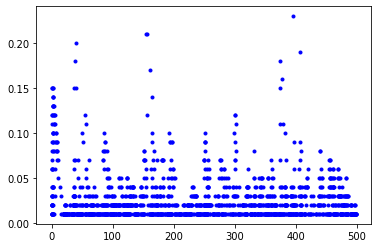

In [16]:
plt.plot(m2r08_Aglf['Ts'],0.01*m2r08_Aglf['life'],'b.')

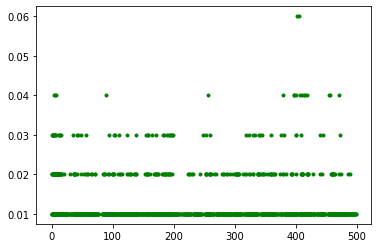

In [17]:
plt.plot(m1r08_Aglf['Ts'],0.01*m1r08_Aglf['life'],'g.')

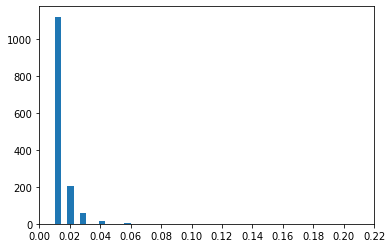

In [18]:
bins = np.arange(0.0,0.24,0.02)

plt.hist(0.01*m1r08_Aglf['life'], bins='auto')
plt.xticks(np.arange(0.0,0.24,0.02))

plt.show()

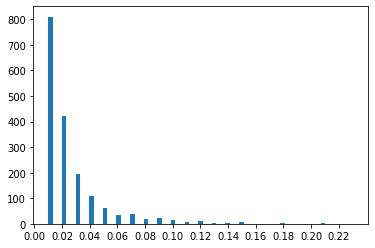

In [19]:
plt.hist(0.01*m2r08_Aglf['life'], bins='auto')

plt.xticks(np.arange(0.0,0.24,0.02))

plt.show()

In [22]:
len(m2r08_Pe)

0

In [24]:
len(m2r08_Uq)

1037

In [25]:
len(m2r08_Ag)

6312

In [27]:
len(m1r08_Pe)

10244

In [28]:
len(m1r08_Uq)

4032

In [29]:
len(m1r08_Ag)

3318